# Import libraries

In [1]:
#Import libraries

import numpy as np
import pandas as pd
from hmmlearn import hmm
import warnings
from sklearn.cluster import KMeans,AffinityPropagation
from scipy.spatial import distance
from constants import *
import matplotlib.pyplot as plt
import collections, operator
import random

### Helper Methods

In [42]:
def count_k_means(kmeans):
    """ Count number of points in each cluster
    kmeans: model
    return: None
    """
    print("K-means")
    counts = {}
    for idx,i in enumerate(kmeans.labels_):
        if(idx%2000==0):
            print("Point", idx, "belongs to cluster",i+1)
        if(i not in counts):
            counts[i]=1
        else:
            counts[i]+=1
    print("********************************************")
    print("********************************************")
    print("Counts of each cluster are")
    for i in range(0,len(counts)):
        print("Cluster",i+1,":",counts[i])

def compute_BIC(kmeans,X):
    """ Compute BIC for k-means clustering
    BIC = -2logL(theta)+log(N)*P, P: free parameters, N: data points
    Lower BIC indicates better fitting models
    For k-means, we use 
    BIC(C) = n*ln(J(C)/n) + k*ln(n)
    J is the Sum of squared distances of samples to their closest cluster center
    n is number of points
    k is number of clusters*parameters estimated
    """

    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    cl_var = (kmeans.inertia_)/N

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return BIC
        
def plot_elbow(list_k, X):
    """ Plot cost function 
    K: for each K in list_k
    X: dataset
    return: plot
    """
    list_score=[]
    for K in list_k:
        kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
        list_score.append(kmeans.inertia_)
    fig = plt.subplot(111)
    plt.plot(list_k, list_score, marker='o')  
    plt.xlabel('Value of K')
    plt.ylabel('Objective')
    plt.title('Elbow Analysis')
    plt.show()     
    
def plot_BIC(list_k, X):
    """ Plot BIC
    K: for each K in list_k
    X: dataset
    return: plot
    """
    list_score=[]
    for K in list_k:
        kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
        list_score.append(compute_BIC(kmeans,X))
    fig = plt.subplot(111)
    plt.plot(list_k, list_score, marker='o')  
    plt.xlabel('Value of K')
    plt.ylabel('Objective')
    plt.title('BIC')
    plt.show()   
def kmeans(X,k):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    X_predicted = [ [] for i in range(k)]
    for x in X:
        X_predicted[kmeans.predict([x])[0]].append(x.tolist())
    return X_predicted

### Exploratory Analysis

In [27]:
#Dataset

df_main = pd.read_csv('Data/merged.txt', sep=",")
df_main = df_main.dropna()
print("Dataset size is",len(df_main))
df_main.head(5)
# X = np.log2(df_main.values)

Dataset size is 11087


,AccNum,GeneName,txReads0,txRPKM0,cdReads0,cdRPKM0,txReads1,txRPKM1,cdReads1,cdRPKM1,txReads2,txRPKM2,cdReads2,cdRPKM2
1,NM_017847,ODR4,24.0,5.523706,13.0,8.539825,15.0,3.433312,9.0,5.879642,18.0,3.434183,11.0,5.990043
5,NM_001003803,ATP5S,16.0,7.776101,10.0,13.837680,5.0,2.416655,3.0,4.128452,8.0,3.223024,6.0,6.882499
6,NM_001003800,BICD2,183.0,25.575552,113.0,39.456786,260.0,36.136825,180.0,62.505536,361.0,41.822764,292.0,84.519655
7,NM_016649,ESF1,8.0,2.230551,6.0,2.104887,11.0,3.050125,10.0,3.488833,12.0,2.773544,10.0,2.908098
8,NM_016647,THEM6,32.0,12.673946,7.0,10.010800,28.0,11.028656,12.0,17.066902,27.0,8.864561,8.0,9.484017


In [28]:
df_main.keys()

Index(['AccNum', 'GeneName', 'txReads0', 'txRPKM0', 'cdReads0', 'cdRPKM0',
       'txReads1', 'txRPKM1', 'cdReads1', 'cdRPKM1', 'txReads2', 'txRPKM2',
       'cdReads2', 'cdRPKM2'],
      dtype='object')

In [29]:
df_main = df_main[(df_main['cdReads0'] >= 10) & (df_main['cdReads1'] >= 10) & (df_main['cdReads2'] >= 10)]

In [30]:
df_main['cdRPKM0'] = np.log2(df_main['cdRPKM0'])
df_main['cdRPKM1'] = np.log2(df_main['cdRPKM1'])
df_main['cdRPKM2'] = np.log2(df_main['cdRPKM2'])

In [31]:
df_main.head()

,AccNum,GeneName,txReads0,txRPKM0,cdReads0,cdRPKM0,txReads1,txRPKM1,cdReads1,cdRPKM1,txReads2,txRPKM2,cdReads2,cdRPKM2
6,NM_001003800,BICD2,183.0,25.575552,113.0,5.302202,260.0,36.136825,180.0,5.965912,361.0,41.822764,292.0,6.401215
13,NM_016640,MRPS30,45.0,24.133178,40.0,4.764058,62.0,33.067123,55.0,5.215526,63.0,28.007488,61.0,5.102235
19,NM_001008781,FAT3,476.0,22.408803,455.0,4.899027,343.0,16.058632,340.0,4.470732,340.0,13.268512,326.0,4.147400
28,NM_003363,USP4,15.0,3.264618,14.0,2.117955,26.0,5.627521,24.0,2.887599,28.0,5.051620,28.0,2.847323
34,NM_001282735,SPATS2L,480.0,67.324760,353.0,7.560309,526.0,73.370594,397.0,7.721817,618.0,71.854447,499.0,7.789049


In [32]:
df_main['foldChange1'] = df_main['cdRPKM1']-df_main['cdRPKM0']
df_main['foldChange2'] = df_main['cdRPKM2']-df_main['cdRPKM0']

In [34]:
RNASeq = df_main

In [35]:
filteredRNASeq = RNASeq[(RNASeq['foldChange1'] <= 0.5) 
                        & (RNASeq['foldChange2'] <= 0.5)
                        ]
filteredRNASeq = filteredRNASeq[(filteredRNASeq['foldChange1'] >= -0.5) 
                                & (filteredRNASeq['foldChange2'] >= -0.5)]

In [36]:
filteredRNASeq.shape

(3028, 16)

In [44]:
X = filteredRNASeq[['foldChange1','foldChange2']].values
# X = df_main[['TE0','TE1','TE2','TE3','TE4']]

In [45]:
X[:5]

array([[0.45146801, 0.33817707],
       [0.16150722, 0.22873946],
       [0.40067612, 0.00722095],
       [0.0295111 , 0.18188004],
       [0.43260898, 0.44557487]])

In [47]:
list_nums = [4,5,6]
for num in list_nums:
    clusters = kmeans(X,num) 
    f = plt.figure(figsize=(15,15))    
    for idx,cluster in enumerate(clusters):
        print(len(cluster))
        genes=[]
        acc_nums=[]
        for row in cluster:
            temp = filteredRNASeq.loc[(filteredRNASeq['foldChange1'] == row[0])& (filteredRNASeq['foldChange2']== row[1])]
            if(not temp.empty):
                genes.append(temp['GeneName'].values[0])
                acc_nums.append(temp['AccNum'].values[0])
        print(len(cluster),len(genes))
        with open('/Users/akankshitadash/Desktop/KMeans/'+str(num)+'/Gene'+str(idx+1)+'.txt','w') as f:
            for gene in genes:
                f.write("%s\n" % gene)
        with open('/Users/akankshitadash/Desktop/KMeans/'+str(num)+'/AccNum'+str(idx+1)+'.txt','w') as f:
            for acc_num in acc_nums:
                f.write("%s\n" % acc_num)
#     plt.savefig('/Users/akankshitadash/Desktop/Heatmap'+str(num))
    plt.show()

725
725 725
829
829 829
656
656 656
818
818 818


673
673 673
671
671 671
616
616 616
470
470 470
598
598 598


499
499 499
562
562 562
396
396 396
529
529 529
553
553 553
489
489 489


In [18]:
# #Dataset
# Z = np.zeros((len(df_main),5))
# for i,array in enumerate(X):
#     delta_1 = (array[1]-array[0])/array[0]
#     delta_2 = (array[2]-array[1])/array[1]
#     Z[i] = np.append(X[i], [delta_1,delta_2])

In [6]:
#Initial K-means with 7 clusters
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

In [7]:
print(kmeans.cluster_centers_)

[[ 2.63581995  2.63258457  2.81455467]
 [ 5.99804468  6.18370591  6.07820929]
 [-0.3192375  -0.34808758 -0.14950861]
 [ 1.28438888  1.36283867  1.630316  ]
 [ 8.04956939  8.1955775   7.89362167]
 [ 4.73948912  4.87517925  4.87163278]
 [ 3.66041642  3.77344738  3.8851796 ]]


In [8]:
count_k_means(kmeans)

K-means
Point 0 belongs to cluster 1
Point 2000 belongs to cluster 2
Point 4000 belongs to cluster 6
Point 6000 belongs to cluster 5
Point 8000 belongs to cluster 7
Point 10000 belongs to cluster 7
********************************************
********************************************
Counts of each cluster are
Cluster 1 : 2362
Cluster 2 : 1355
Cluster 3 : 638
Cluster 4 : 1591
Cluster 5 : 407
Cluster 6 : 2131
Cluster 7 : 2603


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


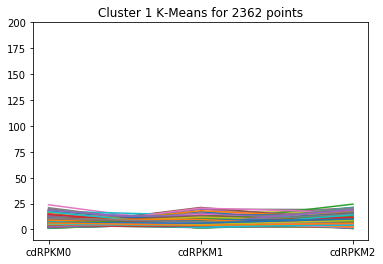

0 2362


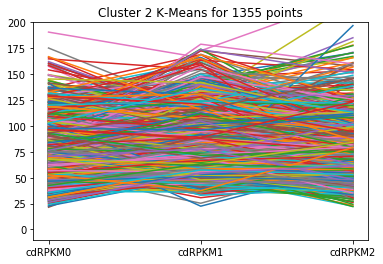

1 1355


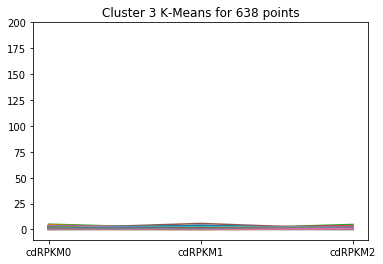

2 638


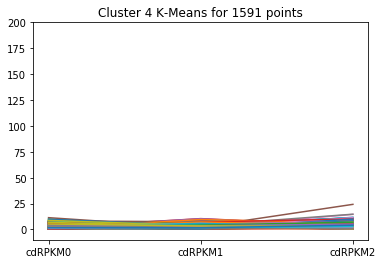

3 1591


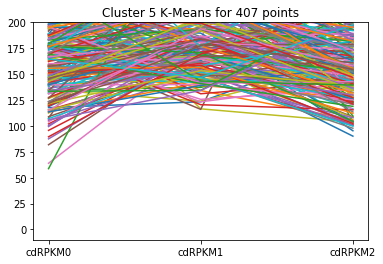

4 407


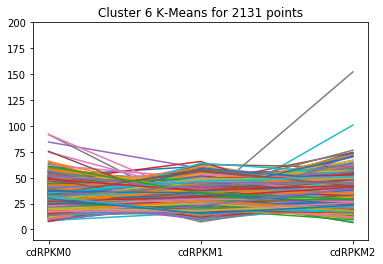

5 2131


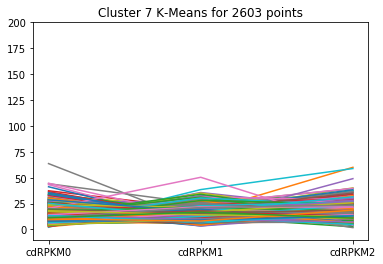

6 2603


In [26]:
var_plot_list = CDRPKM_LIST
for i in range(len(kmeans.cluster_centers_)):
    count=0
    plt.ylim(-10, 200)
    fig = plt.subplot(111)
    for j in range(len(kmeans.labels_)):
        if(kmeans.labels_[j]==i):
            count+=1
            
            fig.plot(var_plot_list,df_main.iloc[j])
    title = "Cluster "+str(i+1)+" K-Means for "+str(count) + " points"
    plt.title(title)
    plt.show()
    print(i,count)

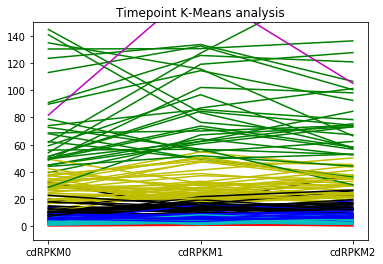

In [9]:
fig = plt.subplot(111)
colors = ['b','g','r','c','m','y','k']
var_plot_list = CDRPKM_LIST
    
for i in range(150):
    fig.plot(var_plot_list, df_main.iloc[i], color = colors[kmeans.labels_[i]])

plt.title("Timepoint K-Means analysis")
plt.ylim(-10, 150)
plt.show()

# Elbow analysis for 2<=K<=20

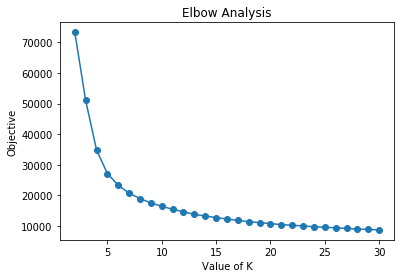

In [26]:
plot_elbow(list(range(2,31,1)),X)

# BIC analysis for 2<=K<=20

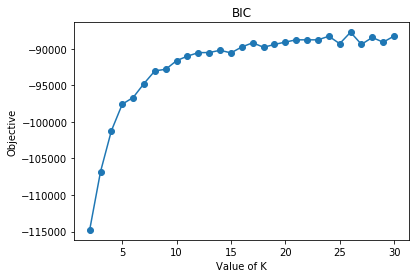

In [27]:
plot_BIC(list(range(2,31,1)),X)

# Affinity Propagation

In [ ]:
clustering = AffinityPropagation(max_iter=5000).fit(Z)
clustering.labels_

In [ ]:
len(clustering.cluster_centers_)